In [ ]:
import mlflow
import pandas as pd
from mlflow import MlflowClient
import numpy as np
import matplotlib.pyplot as plt
from cate.model.plot import 

In [3]:
REMOTE_TRACKING_URI = "http://ec2-44-217-145-52.compute-1.amazonaws.com:5000"
client = MlflowClient(REMOTE_TRACKING_URI)

<Experiment: artifact_location='s3://kaggle-nakayama/mlflow/6', creation_time=1730853199485, experiment_id='6', last_update_time=1730853199485, lifecycle_stage='active', name='base_pattern', tags={}>

In [ ]:
parent_run_id = "0add35cfa1224f2995bffa12ae61e17b"
parent_run = mlflow.get_run(run_id=parent_run_id)
run_ids = mlflow.search_runs(
    filter_string=f"tags.mlflow.parentRunId='{parent_run_id}'",
    order_by=["tags.mlflow.runName DESC"],
).run_id

In [82]:
metrics = {}
for run_id in run_ids:
    metric = {}
    for metrics_column in mlflow.get_run(run_id).data.metrics.keys():
        values = [
            metric_history.value
            for metric_history in client.get_metric_history(run_id, metrics_column)
        ]
        metric[metrics_column] = [np.mean(values), np.std(values)]
    model_name = mlflow.get_run(run_id).data.tags["model"]
    metrics[model_name] = metric
metrics_df = pd.DataFrame(metrics)

In [90]:
metrics_columns = {
    metrics_name: [f"{metrics_name}_at_{i}" for i in range(0, 100, 10)]
    for metrics_name in ["qini", "uplift"]
}

In [ ]:
class Ticks:
    def __init__(
        self,
        ticks: list[str | int | float] | None = None,
        labels: list[str] | None = None,
    ) -> None:
        self.ticks = ticks
        self.labels = labels

    def __call__(self, ax: Axes) -> Axes:
        if self.ticks is not None:
            ax.set_xticks(self.ticks)
        if self.labels is not None:
            ax.set_xticklabels(self.labels)
        return ax


class LinePlot:
    def __init__(self, *, x_ticks: Ticks = Ticks()) -> None:
        self.x_ticks = x_ticks

    def __call__(self, data: pd.DataFrame, title: str, x_label: str, y_label: str) -> Figure:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)

        ax.tick_params(labelsize=14, length=10, width=1)
        ax.set_xlabel(x_label, fontsize=18)
        ax.set_ylabel(y_label, fontsize=18)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(False)

        ax = self.x_ticks(ax)

        ax.plot(data)
        ax.legend(data.columns, fontsize=18, framealpha=0)
        return fig

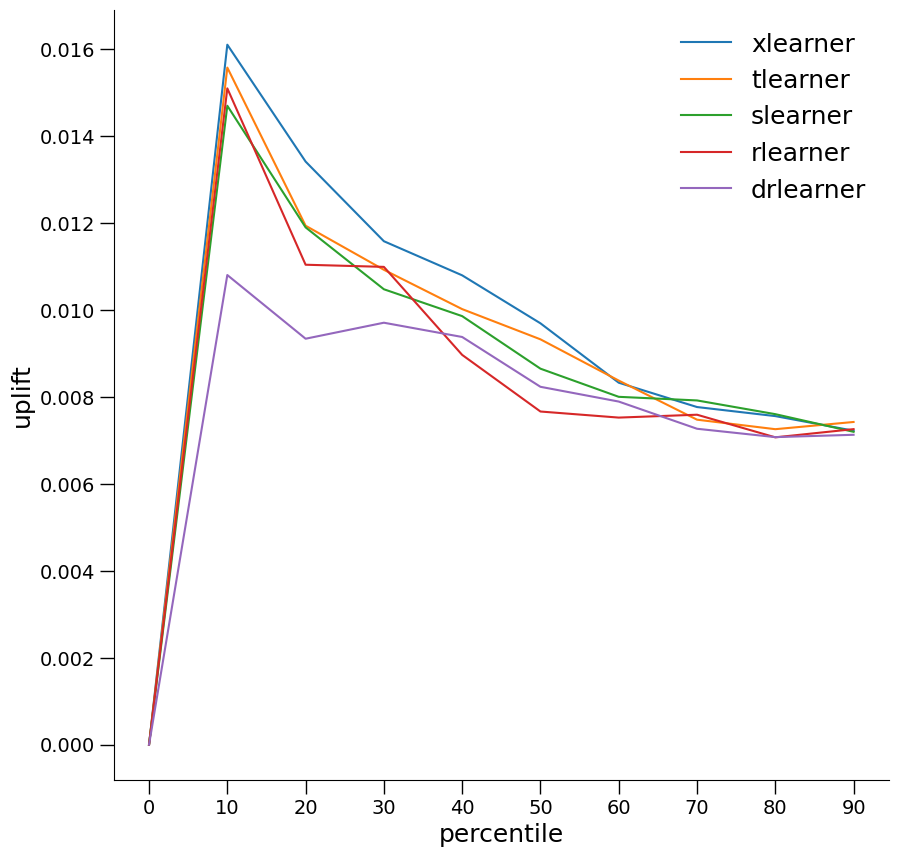

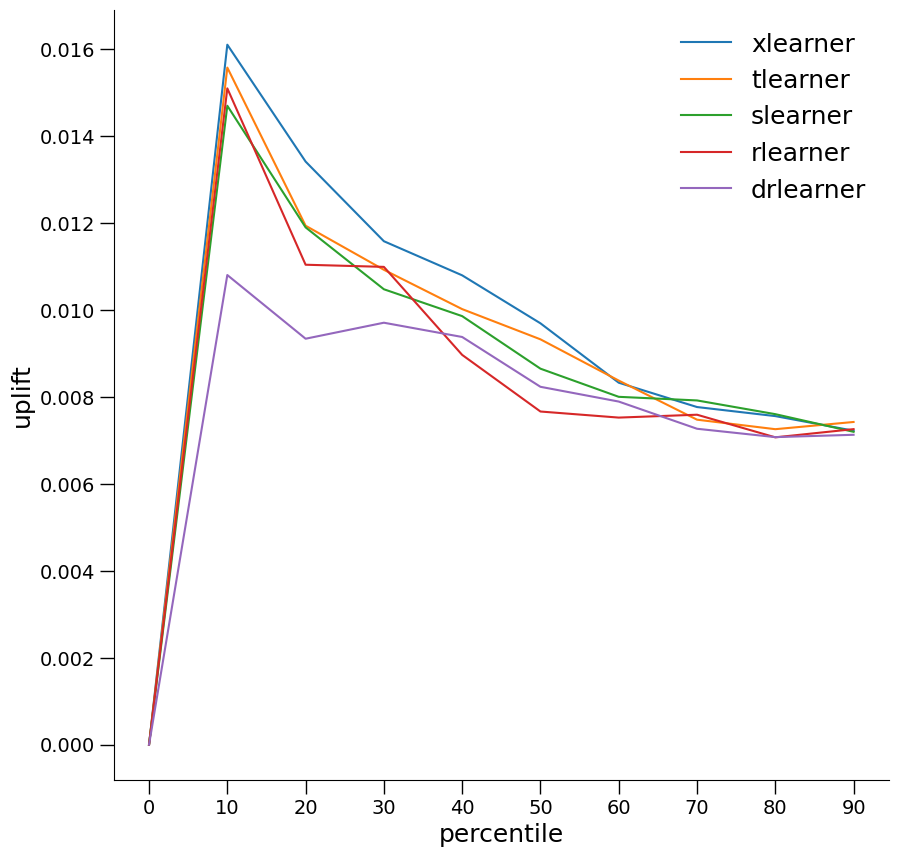

In [93]:
x_ticks = Ticks(
    ticks=list(range(0, 10)), 
    labels=[f"{i}0" if i != 0 else "0" for i in range(0, 10)]
)
line_plot = LinePlot(x_ticks=x_ticks)
line_plot(
    metrics_df.loc[metrics_columns["uplift"], :].map(lambda x: x[0]), 
    "uplift", 
    "percentile", 
    "uplift"
)